In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os
from Bio.Seq import Seq

sys.path.append("../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

# Control variables

In [5]:
# UPDATE list of files and output location
AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/a*")
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/r*")
output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results" # May need to change to your directory due to writing permissions

# Change below as needed to update barcode info, csv path to final step1 map, and desired output directory


step1_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "TATGCTAT",
                       post = "GGCCGGCCG",
                       length = 6)

step1_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "TAGC",
                       post = "CTCGAGA",
                       length = 9)

step1_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GCCCC",
                       post = "GCGG",
                       length = 16)

# Step 1 map
step1_csv = "/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/S1_czb/TL4S1_czb_Min_Maps_and_Graphs_Minimal/TL4S1_10_23_2025_initial_min10_M4_filtered_map4_unique_Cat/TL4S1_10_23_2025_initial_min10_TL4S1_czb_Min_map4_unique_cat_map4_90_match_10_read_min_filter.csv"

In [6]:

# PReviously using wrong below
# step1_ADBC2 = finder.Barcode(name = "ADBC2",
#                        preceder = "TGCTAT",
#                        post = "GGCCGGCC",
#                        length = 6)

# # Example DNA sequence
# seq = Seq("GCTA")  # includes ambiguous bases

# # Reverse complement
# rev_comp = seq.reverse_complement()

# print(rev_comp)  # Output: YRNACGGCAT

# From CC (Need to take rc to work with my code)

# ADBC2
# bc2_pre="CGGCCGGCC", 
# bc2_post="ATAGCATA", 

# Hawk
# bc1_pre="TCTCGAG", 
# bc1_post="GCTA"):


# pre: CCGC
# post: GGGGC


# First, AD analysis

In [7]:
db_path = os.path.join(output_path, "NKX2-2_CC_UMI.db")

In [8]:
AD_objects = [step1_ADBC2, step1_HawkBCs]

In [9]:
complex_AD_results = []
simple_AD_results = []

In [7]:
for file_path in AD_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = AD_objects,
                                       reverse_complement = True,
                                       umi_length = 12)
    umi_map = umi_mapper.create_map()

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=AD_objects,
                                        column_pairs = [],
                                        reads_threshold = 1,
                                        map_order = ['quality_designed'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "")
    refiner.refine_map_from_db()

    

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_AD_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_AD_results.append(one_file_simple_results)

a2_RNA_ADBC_S18
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a2_RNA_ADBC_S18
a7_RNA_ADBC_S23
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a7_RNA_ADBC_S23
a1_RNA_ADBC_S17
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a1_RNA_ADBC_S17
a3_RNA_ADBC_S19
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a3_RNA_ADBC_S19
a6_RNA_ADBC_S22
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a6_RNA_ADBC_S22
a4_RNA_ADBC_S20
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a4_RNA_ADBC_S20
a8_RNA_ADBC_S24
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a8_RNA_ADBC_S24
a5_RNA_ADBC_S21
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_a5_RNA_ADBC_S21


In [8]:
all_complex_AD_results_df = pd.concat(complex_AD_results)
all_complex_AD_results_df = all_complex_AD_results_df.rename(columns = {"count" : "AD_umi_count", "gene" : "ADBC_concat"})
all_complex_AD_results_df["number"] = all_complex_AD_results_df["name"].str[1]
all_complex_AD_results_df

,ADBC_concat,AD_umi_count,name,number
0,GGAAATAGTCCAGTT,1349,a2_RNA_ADBC_S18,2
1,TTTCATCCATCGGTT,13,a2_RNA_ADBC_S18,2
2,AGAGTCAACCAGAAC,459,a2_RNA_ADBC_S18,2
3,ATCAGACATTCGTAC,391,a2_RNA_ADBC_S18,2
4,AAGCAGCATCCTGTC,2601,a2_RNA_ADBC_S18,2
...,...,...,...,...
4698,AAATTCCCGCGGTAT,1,a5_RNA_ADBC_S21,5
4699,GCGCGACAGCGCATT,1,a5_RNA_ADBC_S21,5
4700,TAATCCACCTATCAC,1,a5_RNA_ADBC_S21,5
4701,ATGGCGAGAATTGTG,1,a5_RNA_ADBC_S21,5


In [9]:
all_complex_AD_results_df.to_csv(os.path.join(output_path, f"all_complex_AD_results.csv"))

In [10]:
all_simple_AD_results_df = pd.concat(simple_AD_results)
all_simple_AD_results_df = all_simple_AD_results_df.rename(columns = {"count" : "AD_umi_count"})
all_simple_AD_results_df["ADBC_concat"] = all_simple_AD_results_df["ADBC2"] + all_simple_AD_results_df["HawkBCs"]
all_simple_AD_results_df["number"] = all_simple_AD_results_df["name"].str[1]
all_simple_AD_results_df

,ADBC2,HawkBCs,AD_umi_count,name,ADBC_concat,number
0,GGTTAT,CACAACTTC,11885,a2_RNA_ADBC_S18,GGTTATCACAACTTC,2
1,CCATAA,CACCGATTG,8879,a2_RNA_ADBC_S18,CCATAACACCGATTG,2
2,GCCTGT,CACAACTTC,7032,a2_RNA_ADBC_S18,GCCTGTCACAACTTC,2
3,AGACTA,CACAACTTC,6654,a2_RNA_ADBC_S18,AGACTACACAACTTC,2
4,CGAGTC,CACAACTTC,6298,a2_RNA_ADBC_S18,CGAGTCCACAACTTC,2
...,...,...,...,...,...,...
4698,CAAACG,ACTCTTGCA,1,a5_RNA_ADBC_S21,CAAACGACTCTTGCA,5
4699,TGTATA,CCAGCCAAT,1,a5_RNA_ADBC_S21,TGTATACCAGCCAAT,5
4700,ATTCTT,CAAGACCTA,1,a5_RNA_ADBC_S21,ATTCTTCAAGACCTA,5
4701,AACCAA,CATTCCAAG,1,a5_RNA_ADBC_S21,AACCAACATTCCAAG,5


In [11]:
all_simple_AD_results_df.to_csv(os.path.join(output_path, f"all_simple_AD_results.csv"))

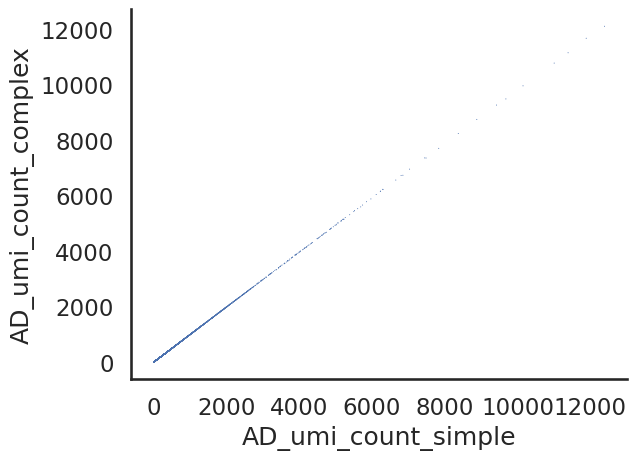

In [29]:
# Both simple and complex counts are roughly y = x which checks out!
AD_results_merged = pd.merge(all_complex_AD_results_df, all_simple_AD_results_df, on = ["ADBC_concat", "name", "number"],suffixes = ("_complex", "_simple"))
sns.scatterplot(data = AD_results_merged, x = "AD_umi_count_simple", y = "AD_umi_count_complex", s  = 0.5, edgecolor = 'none')
sns.despine()
plt.savefig(os.path.join(output_path, f"AD_umi_count_comparison.png"), bbox_inches='tight')

# Next, RPTR analysis

In [13]:
RTBC_objects = [step1_RTBC]

In [14]:
complex_RPTR_results = []
simple_RPTR_results = []

In [15]:
for file_path in RT_seq_files:
    
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Get the file naeme to use for output
    umi_path = os.path.join(output_path, f"umi_{name_only}")
    print(umi_path)

    # Extract UMIs and barcodes from reads
    umi_mapper = initial_map.InitialMapper(db_path = db_path,
                                       step_name = f"umi_{name_only}", 
                                       seq_file = file_path,
                                       design_file_path = None,
                                       bc_objects = [step1_RTBC],
                                       reverse_complement = True,
                                       umi_length = 12)
    umi_map = umi_mapper.create_map()

    # Only keep barcodes of correct length
    refiner = map_refiner.MapRefiner(db_path = db_path,
                                        bc_objects=RTBC_objects,
                                        column_pairs = [],
                                        reads_threshold = 1,
                                        map_order = ['quality_designed'],
                                        step_name=f"umi_{name_only}", 
                                        descriptor = "")
    refiner.refine_map_from_db()

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    deduplicator.run_both_deduplications()

    # Collect results
    one_file_complex_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_directional_umi_counts.tsv"), sep = "\t")
    one_file_complex_results["name"] = name_only
    complex_RPTR_results.append(one_file_complex_results)

    one_file_simple_results = pd.read_csv(os.path.join(umi_path, f"{name_only}_simple_umi_counts.tsv"), sep = "\t")
    one_file_simple_results["name"] = name_only
    simple_RPTR_results.append(one_file_simple_results)

r2_RNA_RTBC_S26
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r2_RNA_RTBC_S26
r8_RNA_RTBC_S32
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r8_RNA_RTBC_S32
r7_RNA_RTBC_S31
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r7_RNA_RTBC_S31
r1_RNA_RTBC_S25
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r1_RNA_RTBC_S25
r6_RNA_RTBC_S30
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r6_RNA_RTBC_S30
r3_RNA_RTBC_S27
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r3_RNA_RTBC_S27
r5_RNA_RTBC_S29
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r5_RNA_RTBC_S29
r4_RNA_RTBC_S28
/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/TL4_umi_results/umi_r4_RNA_RTBC_S28


In [16]:
all_complex_RPTR_results_df = pd.concat(complex_RPTR_results)
all_complex_RPTR_results_df = all_complex_RPTR_results_df.rename(columns = {"count" : "RTBC_umi_count", "gene" : "RTBC"})
all_complex_RPTR_results_df["number"] = all_complex_RPTR_results_df["name"].str[1]
all_complex_RPTR_results_df

,RTBC,RTBC_umi_count,name,number
0,CCCCAGGCACTATAAG,816,r2_RNA_RTBC_S26,2
1,CGGAAATTCAAAAATC,108,r2_RNA_RTBC_S26,2
2,AAAACTTTCAACGTAC,71,r2_RNA_RTBC_S26,2
3,TCGAGATTGAATGCAT,321,r2_RNA_RTBC_S26,2
4,GGAGCCAGGCTAATTT,311,r2_RNA_RTBC_S26,2
...,...,...,...,...
9035,CTGTGGTCATAAAAAG,1,r4_RNA_RTBC_S28,4
9036,GTCAAGCAAAATTTAA,1,r4_RNA_RTBC_S28,4
9037,ATGAACATTGTGGAAA,1,r4_RNA_RTBC_S28,4
9038,TATCTCTAATAAACTA,1,r4_RNA_RTBC_S28,4


In [17]:
all_complex_RPTR_results_df.to_csv(os.path.join(output_path, f"all_complex_RPTR_results.csv"))

In [18]:
all_simple_RPTR_results_df = pd.concat(simple_RPTR_results)
all_simple_RPTR_results_df = all_simple_RPTR_results_df.rename(columns = {"count" : "RTBC_umi_count"})
all_simple_RPTR_results_df["number"] = all_simple_RPTR_results_df["name"].str[1]
all_simple_RPTR_results_df

,RTBC,RTBC_umi_count,name,number
0,TTGACTATAATACATA,9732,r2_RNA_RTBC_S26,2
1,AGATATGCTTCTCGAT,9091,r2_RNA_RTBC_S26,2
2,ATGACAATGAACATAT,8516,r2_RNA_RTBC_S26,2
3,CGAGCCTATAGCATAA,8495,r2_RNA_RTBC_S26,2
4,ATTTTTGAATTTTTAT,7401,r2_RNA_RTBC_S26,2
...,...,...,...,...
9035,AATTTTATAGGAGATT,1,r4_RNA_RTBC_S28,4
9036,ACTCCAAAGCATGCTA,1,r4_RNA_RTBC_S28,4
9037,AAAATTATTTAAATTA,1,r4_RNA_RTBC_S28,4
9038,TCATTATATCCGAGAC,1,r4_RNA_RTBC_S28,4


In [19]:
all_simple_RPTR_results_df.to_csv(os.path.join(output_path, f"all_simple_RPTR_results.csv"))

In [28]:
# Both simple and complex counts are roughly y = x which checks out!
RPTR_results_merged = pd.merge(all_complex_RPTR_results_df, all_simple_RPTR_results_df, on = ["RTBC", "name", "number"],suffixes = ("_complex", "_simple"))
sns.scatterplot(data = RPTR_results_merged, x = "RTBC_umi_count_simple", y = "RTBC_umi_count_complex", s  = 0.5, edgecolor = 'none')
sns.despine()
plt.savefig(os.path.join(output_path, f"RPTR_umi_count_comparison.png"), bbox_inches='tight')
plt.close()

# Now, merge with step1 map

In [14]:
step1_map = pd.read_csv(step1_csv)
step1_map

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172
1,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACG-GTCAGC-TGTAAAATGGGGCTGG-GACTCTCCCGGA...,CCATTAACG-GTCAGC,CCATTAACG-GTCAGC-TGTAAAATGGGGCTGG,9261
2,GTACAA,CCATCGGTT,TTGCAGAATAGCTGCA,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,CCATCGGTT-GTACAA-TTGCAGAATAGCTGCA-GACTCTCCCGGA...,CCATCGGTT-GTACAA,CCATCGGTT-GTACAA-TTGCAGAATAGCTGCA,7239
3,TGGGAC,ACCGGATGT,CACAAAACGTGGCGCC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,ACCGGATGT-TGGGAC-CACAAAACGTGGCGCC-GCCCAGGACCTG...,ACCGGATGT-TGGGAC,ACCGGATGT-TGGGAC-CACAAAACGTGGCGCC,7042
4,CTAATA,ATCAGGACC,CAGGAAATCCCTCTAT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,ATCAGGACC-CTAATA-CAGGAAATCCCTCTAT-GCCCAGGACCTG...,ATCAGGACC-CTAATA,ATCAGGACC-CTAATA-CAGGAAATCCCTCTAT,6387
...,...,...,...,...,...,...,...,...
1748,GCACCA,ACTCCACAT,GTAAAGAAGAAATGTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,ACTCCACAT-GCACCA-GTAAAGAAGAAATGTC-GCCCAGGACCTG...,ACTCCACAT-GCACCA,ACTCCACAT-GCACCA-GTAAAGAAGAAATGTC,10
1749,CCGGAA,AACTTCTGG,CATGAATCCTCTTTTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGGCGCTCCCAGCGCCT...,AACTTCTGG-CCGGAA-CATGAATCCTCTTTTC-GCCCAGGACCTG...,AACTTCTGG-CCGGAA,AACTTCTGG-CCGGAA-CATGAATCCTCTTTTC,10
1750,GCTAGC,ACTTCCTCT,AAGCATTTGATGTTTA,GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...,ACTTCCTCT-GCTAGC-AAGCATTTGATGTTTA-GCCCAGGACCTG...,ACTTCCTCT-GCTAGC,ACTTCCTCT-GCTAGC-AAGCATTTGATGTTTA,10
1751,AAGCCT,AGCCGTAGA,CCTTAAAACCGAAAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA-GCCCAGGACCTG...,AGCCGTAGA-AAGCCT,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA,10


In [47]:
# Concatenated ADBC2 and HawkBC
step1_map["ADBC_concat"] = step1_map["ADBC2"] + step1_map["HawkBCs"] 
step1_map

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count,ADBC_concat
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG
1,GTCAGC,CCATTAACG,TGTAAAATGGGGCTGG,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCTACG...,CCATTAACG-GTCAGC-TGTAAAATGGGGCTGG-GACTCTCCCGGA...,CCATTAACG-GTCAGC,CCATTAACG-GTCAGC-TGTAAAATGGGGCTGG,9261,GTCAGCCCATTAACG
2,GTACAA,CCATCGGTT,TTGCAGAATAGCTGCA,GACTCTCCCGGACCCGGCTTCACACCTCACGACAGCGCTCCCGCCG...,CCATCGGTT-GTACAA-TTGCAGAATAGCTGCA-GACTCTCCCGGA...,CCATCGGTT-GTACAA,CCATCGGTT-GTACAA-TTGCAGAATAGCTGCA,7239,GTACAACCATCGGTT
3,TGGGAC,ACCGGATGT,CACAAAACGTGGCGCC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,ACCGGATGT-TGGGAC-CACAAAACGTGGCGCC-GCCCAGGACCTG...,ACCGGATGT-TGGGAC,ACCGGATGT-TGGGAC-CACAAAACGTGGCGCC,7042,TGGGACACCGGATGT
4,CTAATA,ATCAGGACC,CAGGAAATCCCTCTAT,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCG...,ATCAGGACC-CTAATA-CAGGAAATCCCTCTAT-GCCCAGGACCTG...,ATCAGGACC-CTAATA,ATCAGGACC-CTAATA-CAGGAAATCCCTCTAT,6387,CTAATAATCAGGACC
...,...,...,...,...,...,...,...,...,...
1748,GCACCA,ACTCCACAT,GTAAAGAAGAAATGTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,ACTCCACAT-GCACCA-GTAAAGAAGAAATGTC-GCCCAGGACCTG...,ACTCCACAT-GCACCA,ACTCCACAT-GCACCA-GTAAAGAAGAAATGTC,10,GCACCAACTCCACAT
1749,CCGGAA,AACTTCTGG,CATGAATCCTCTTTTC,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGGCGCTCCCAGCGCCT...,AACTTCTGG-CCGGAA-CATGAATCCTCTTTTC-GCCCAGGACCTG...,AACTTCTGG-CCGGAA,AACTTCTGG-CCGGAA-CATGAATCCTCTTTTC,10,CCGGAAAACTTCTGG
1750,GCTAGC,ACTTCCTCT,AAGCATTTGATGTTTA,GCCCAGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCA...,ACTTCCTCT-GCTAGC-AAGCATTTGATGTTTA-GCCCAGGACCTG...,ACTTCCTCT-GCTAGC,ACTTCCTCT-GCTAGC-AAGCATTTGATGTTTA,10,GCTAGCACTTCCTCT
1751,AAGCCT,AGCCGTAGA,CCTTAAAACCGAAAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA-GCCCAGGACCTG...,AGCCGTAGA-AAGCCT,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA,10,AAGCCTAGCCGTAGA


In [53]:
# Add simple AD UMI counts to step1 map
step1_map_with_AD = pd.merge(step1_map, AD_results_merged).drop_duplicates()
step1_map_with_AD

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count,ADBC_concat,AD_umi_count_complex,name,number,AD_umi_count_simple
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,8746,a2_RNA_ADBC_S18,2,8879
1,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,9264,a7_RNA_ADBC_S23,7,9421
2,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,7704,a1_RNA_ADBC_S17,1,7833
3,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,12101,a3_RNA_ADBC_S19,3,12387
4,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,6728,a6_RNA_ADBC_S22,6,6800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8864,AATCGA,CCACCTTAC,CAACCATAGGCGTCTG,CCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGG...,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG-CCCACCGACGTG...,CCACCTTAC-AATCGA,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG,10,AATCGACCACCTTAC,850,a3_RNA_ADBC_S19,3,852
8865,AATCGA,CCACCTTAC,CAACCATAGGCGTCTG,CCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGG...,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG-CCCACCGACGTG...,CCACCTTAC-AATCGA,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG,10,AATCGACCACCTTAC,152,a6_RNA_ADBC_S22,6,153
8866,AATCGA,CCACCTTAC,CAACCATAGGCGTCTG,CCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGG...,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG-CCCACCGACGTG...,CCACCTTAC-AATCGA,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG,10,AATCGACCACCTTAC,525,a4_RNA_ADBC_S20,4,527
8867,AATCGA,CCACCTTAC,CAACCATAGGCGTCTG,CCCACCGACGTGAGCCTGGGCGACGAGCTGCACCTGGACGGCGAGG...,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG-CCCACCGACGTG...,CCACCTTAC-AATCGA,CCACCTTAC-AATCGA-CAACCATAGGCGTCTG,10,AATCGACCACCTTAC,798,a8_RNA_ADBC_S24,8,800


In [54]:
# Add RPTR UMI counts to step1 map
step1_map_with_RPTR = pd.merge(step1_map, RPTR_results_merged).drop_duplicates()
step1_map_with_RPTR

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count,ADBC_concat,RTBC_umi_count_complex,name,number,RTBC_umi_count_simple
0,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,5217,r2_RNA_RTBC_S26,2,5278
1,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,7766,r8_RNA_RTBC_S32,8,7921
2,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,7987,r7_RNA_RTBC_S31,7,8169
3,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,5334,r1_RNA_RTBC_S25,1,5434
4,CCATAA,CACCGATTG,CAGCGTTTAACAAGCG,GCCGGCGACCTGGCCGCCGCCACCTTCGGCGCCGGCATTCCCTTCA...,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG-GCCGGCGACCTG...,CACCGATTG-CCATAA,CACCGATTG-CCATAA-CAGCGTTTAACAAGCG,11172,CCATAACACCGATTG,4743,r6_RNA_RTBC_S30,6,4817
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,AAGCCT,AGCCGTAGA,CCTTAAAACCGAAAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA-GCCCAGGACCTG...,AGCCGTAGA-AAGCCT,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA,10,AAGCCTAGCCGTAGA,46,r1_RNA_RTBC_S25,1,46
9125,AAGCCT,AGCCGTAGA,CCTTAAAACCGAAAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA-GCCCAGGACCTG...,AGCCGTAGA-AAGCCT,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA,10,AAGCCTAGCCGTAGA,11,r6_RNA_RTBC_S30,6,11
9126,AAGCCT,AGCCGTAGA,CCTTAAAACCGAAAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA-GCCCAGGACCTG...,AGCCGTAGA-AAGCCT,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA,10,AAGCCTAGCCGTAGA,5,r3_RNA_RTBC_S27,3,5
9127,AAGCCT,AGCCGTAGA,CCTTAAAACCGAAAGA,GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCA...,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA-GCCCAGGACCTG...,AGCCGTAGA-AAGCCT,AGCCGTAGA-AAGCCT-CCTTAAAACCGAAAGA,10,AAGCCTAGCCGTAGA,5,r5_RNA_RTBC_S29,5,5


In [69]:
merge_cols = set(step1_map_with_AD.columns) & set(step1_map_with_RPTR.columns)
merge_cols = [col for col in list(merge_cols) if col != "name"]
merge_cols

['HawkBCs',
 'Designed',
 'ADBC_concat',
 'ADBC2',
 'Cat',
 'HA',
 'number',
 'RTBC',
 'Cat_Count',
 'HAR']

In [70]:
step1_map_with_AD_RPTR = pd.merge(step1_map_with_AD, step1_map_with_RPTR, on = merge_cols, how = 'outer', suffixes = ("_AD", "_RPTR"))
step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.fillna(0)
step1_map_with_AD_RPTR

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count,ADBC_concat,AD_umi_count_complex,name_AD,number,AD_umi_count_simple,RTBC_umi_count_complex,name_RPTR,RTBC_umi_count_simple
0,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,793.0,a1_RNA_ADBC_S17,1,795.0,819.0,r1_RNA_RTBC_S25,825.0
1,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,1009.0,a2_RNA_ADBC_S18,2,1013.0,1030.0,r2_RNA_RTBC_S26,1033.0
2,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,810.0,a5_RNA_ADBC_S21,5,813.0,291.0,r5_RNA_RTBC_S29,293.0
3,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,603.0,a6_RNA_ADBC_S22,6,604.0,512.0,r6_RNA_RTBC_S30,514.0
4,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,1.0,a7_RNA_ADBC_S23,7,1.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,200.0,a4_RNA_ADBC_S20,4,200.0,194.0,r4_RNA_RTBC_S28,194.0
9571,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,801.0,a5_RNA_ADBC_S21,5,807.0,312.0,r5_RNA_RTBC_S29,314.0
9572,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,753.0,a6_RNA_ADBC_S22,6,758.0,421.0,r6_RNA_RTBC_S30,422.0
9573,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,227.0,a7_RNA_ADBC_S23,7,229.0,153.0,r7_RNA_RTBC_S31,153.0


In [71]:
# Now, break down into a better more manageable table
# 1	R1N 24
# 2	R1incuded 24
# 3	R2N 24
# 4	R2Induced 24
# 5	R1N 48
# 6	R1incuded 48
# 7	R2N 48
# 8	R2Induced 48

# Define a mapping for each attribute
mapping = {
    "1": {"Replicate": "R1", "Induced": "No",  "Time": 24},
    "2": {"Replicate": "R1", "Induced": "Yes", "Time": 24},
    "3": {"Replicate": "R2", "Induced": "No",  "Time": 24},
    "4": {"Replicate": "R2", "Induced": "Yes", "Time": 24},
    "5": {"Replicate": "R1", "Induced": "No",  "Time": 48},
    "6": {"Replicate": "R1", "Induced": "Yes", "Time": 48},
    "7": {"Replicate": "R2", "Induced": "No",  "Time": 48},
    "8": {"Replicate": "R2", "Induced": "Yes", "Time": 48},
}

# Expand mapping into separate columns
step1_map_with_AD_RPTR = step1_map_with_AD_RPTR.join(step1_map_with_AD_RPTR["number"].map(mapping).apply(pd.Series))
step1_map_with_AD_RPTR

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count,ADBC_concat,AD_umi_count_complex,name_AD,number,AD_umi_count_simple,RTBC_umi_count_complex,name_RPTR,RTBC_umi_count_simple,Replicate,Induced,Time
0,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,793.0,a1_RNA_ADBC_S17,1,795.0,819.0,r1_RNA_RTBC_S25,825.0,R1,No,24
1,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,1009.0,a2_RNA_ADBC_S18,2,1013.0,1030.0,r2_RNA_RTBC_S26,1033.0,R1,Yes,24
2,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,810.0,a5_RNA_ADBC_S21,5,813.0,291.0,r5_RNA_RTBC_S29,293.0,R1,No,48
3,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,603.0,a6_RNA_ADBC_S22,6,604.0,512.0,r6_RNA_RTBC_S30,514.0,R1,Yes,48
4,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,1.0,a7_RNA_ADBC_S23,7,1.0,0.0,0,0.0,R2,No,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,200.0,a4_RNA_ADBC_S20,4,200.0,194.0,r4_RNA_RTBC_S28,194.0,R2,Yes,24
9571,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,801.0,a5_RNA_ADBC_S21,5,807.0,312.0,r5_RNA_RTBC_S29,314.0,R1,No,48
9572,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,753.0,a6_RNA_ADBC_S22,6,758.0,421.0,r6_RNA_RTBC_S30,422.0,R1,Yes,48
9573,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,227.0,a7_RNA_ADBC_S23,7,229.0,153.0,r7_RNA_RTBC_S31,153.0,R2,No,48


In [72]:
# Final results 
final_results = step1_map_with_AD_RPTR
final_results

,ADBC2,HawkBCs,RTBC,Designed,Cat,HA,HAR,Cat_Count,ADBC_concat,AD_umi_count_complex,name_AD,number,AD_umi_count_simple,RTBC_umi_count_complex,name_RPTR,RTBC_umi_count_simple,Replicate,Induced,Time
0,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,793.0,a1_RNA_ADBC_S17,1,795.0,819.0,r1_RNA_RTBC_S25,825.0,R1,No,24
1,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,1009.0,a2_RNA_ADBC_S18,2,1013.0,1030.0,r2_RNA_RTBC_S26,1033.0,R1,Yes,24
2,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,810.0,a5_RNA_ADBC_S21,5,813.0,291.0,r5_RNA_RTBC_S29,293.0,R1,No,48
3,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,603.0,a6_RNA_ADBC_S22,6,604.0,512.0,r6_RNA_RTBC_S30,514.0,R1,Yes,48
4,TATTAT,AACAACACC,TAGGAAACTTATATTG,GCCCAGGACCTGAGCCTGAGCACCTTCCAGGCCGGCATTCCCTTCA...,AACAACACC-TATTAT-TAGGAAACTTATATTG-GCCCAGGACCTG...,AACAACACC-TATTAT,AACAACACC-TATTAT-TAGGAAACTTATATTG,762,TATTATAACAACACC,1.0,a7_RNA_ADBC_S23,7,1.0,0.0,0,0.0,R2,No,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9570,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,200.0,a4_RNA_ADBC_S20,4,200.0,194.0,r4_RNA_RTBC_S28,194.0,R2,Yes,24
9571,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,801.0,a5_RNA_ADBC_S21,5,807.0,312.0,r5_RNA_RTBC_S29,314.0,R1,No,48
9572,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,753.0,a6_RNA_ADBC_S22,6,758.0,421.0,r6_RNA_RTBC_S30,422.0,R1,Yes,48
9573,TACCAC,CCGTTCAGA,CTTAGAAACATTTTTA,GGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCA...,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA-GGCAGCGGCAGC...,CCGTTCAGA-TACCAC,CCGTTCAGA-TACCAC-CTTAGAAACATTTTTA,739,TACCACCCGTTCAGA,227.0,a7_RNA_ADBC_S23,7,229.0,153.0,r7_RNA_RTBC_S31,153.0,R2,No,48


In [73]:
#231 distinct ADs in final results
final_results["Designed"].value_counts()

Designed
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCAGAGCCTGCAGCACATGCAGTACAACGCCCAGTACAGCAGCGCCAGCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    166
GCCCTGGACCTGGCCGCCGCCACCTTCCTGGCCGGCATTCCCTTCAGCGCCTACAGCGCCCTGAGCCTGCTGCACATGCTGTACAACGCCCTGTACAGCAGCGCCAGCACACCTCTGTATCCCACCGCCCATCCTCTGGTGCTGGCCCTGCTGTGGACCTGG    137
GCCCAGGACCTGGCCGCCGCCACCTTCCAGGCCGGCATTCCCTTCACCGCCTACACCGCCCAGACCCTGCAGCACATGCAGTACAACGCCCAGTACACCACCGCCACCACACCTCAGTATCCCACCGCCCATCCTCTGGTGCAGGCCCAGCAGTGGACCTGG    118
ACCGACTTCATCGACGAGGAGGTGCTGATGAGCCTGGTGATCGAGATGGGCCTGGACAGAATCAAGAAGCTGCCCAAGCTGTGGCTGGGCCAGAACAAGTTCAAGTTCATGACCAAGGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGCAGCGGC     99
GCTCCCGACCTGGCCGCCGCCACCTTTCCCGCCGGCATTCCCTTCAGCGCCTACAGCGCTCCCAGCCTGCCTCACATGCCCTACAACGCTCCCTACAGCAGCGCCAGCACACCTCCCTATCCCACCGCCCATCCTCTGGTGCCCGCTCCTCCCTGGACCTGG     93
                                                                                                                                             

In [74]:
step1_map_with_AD_RPTR.to_csv(os.path.join(output_path, f"results_with_step1.csv"))

# BC Quality Loss

umi_a1_RNA_ADBC_S17_ADBC2_HawkBCs_initial step1 count: 589287
umi_a2_RNA_ADBC_S18_ADBC2_HawkBCs_initial step1 count: 686434
umi_a3_RNA_ADBC_S19_ADBC2_HawkBCs_initial step1 count: 607682
umi_a4_RNA_ADBC_S20_ADBC2_HawkBCs_initial step1 count: 556830
umi_a5_RNA_ADBC_S21_ADBC2_HawkBCs_initial step1 count: 624628
umi_a6_RNA_ADBC_S22_ADBC2_HawkBCs_initial step1 count: 532772
umi_a7_RNA_ADBC_S23_ADBC2_HawkBCs_initial step1 count: 492191
umi_a8_RNA_ADBC_S24_ADBC2_HawkBCs_initial step1 count: 607587


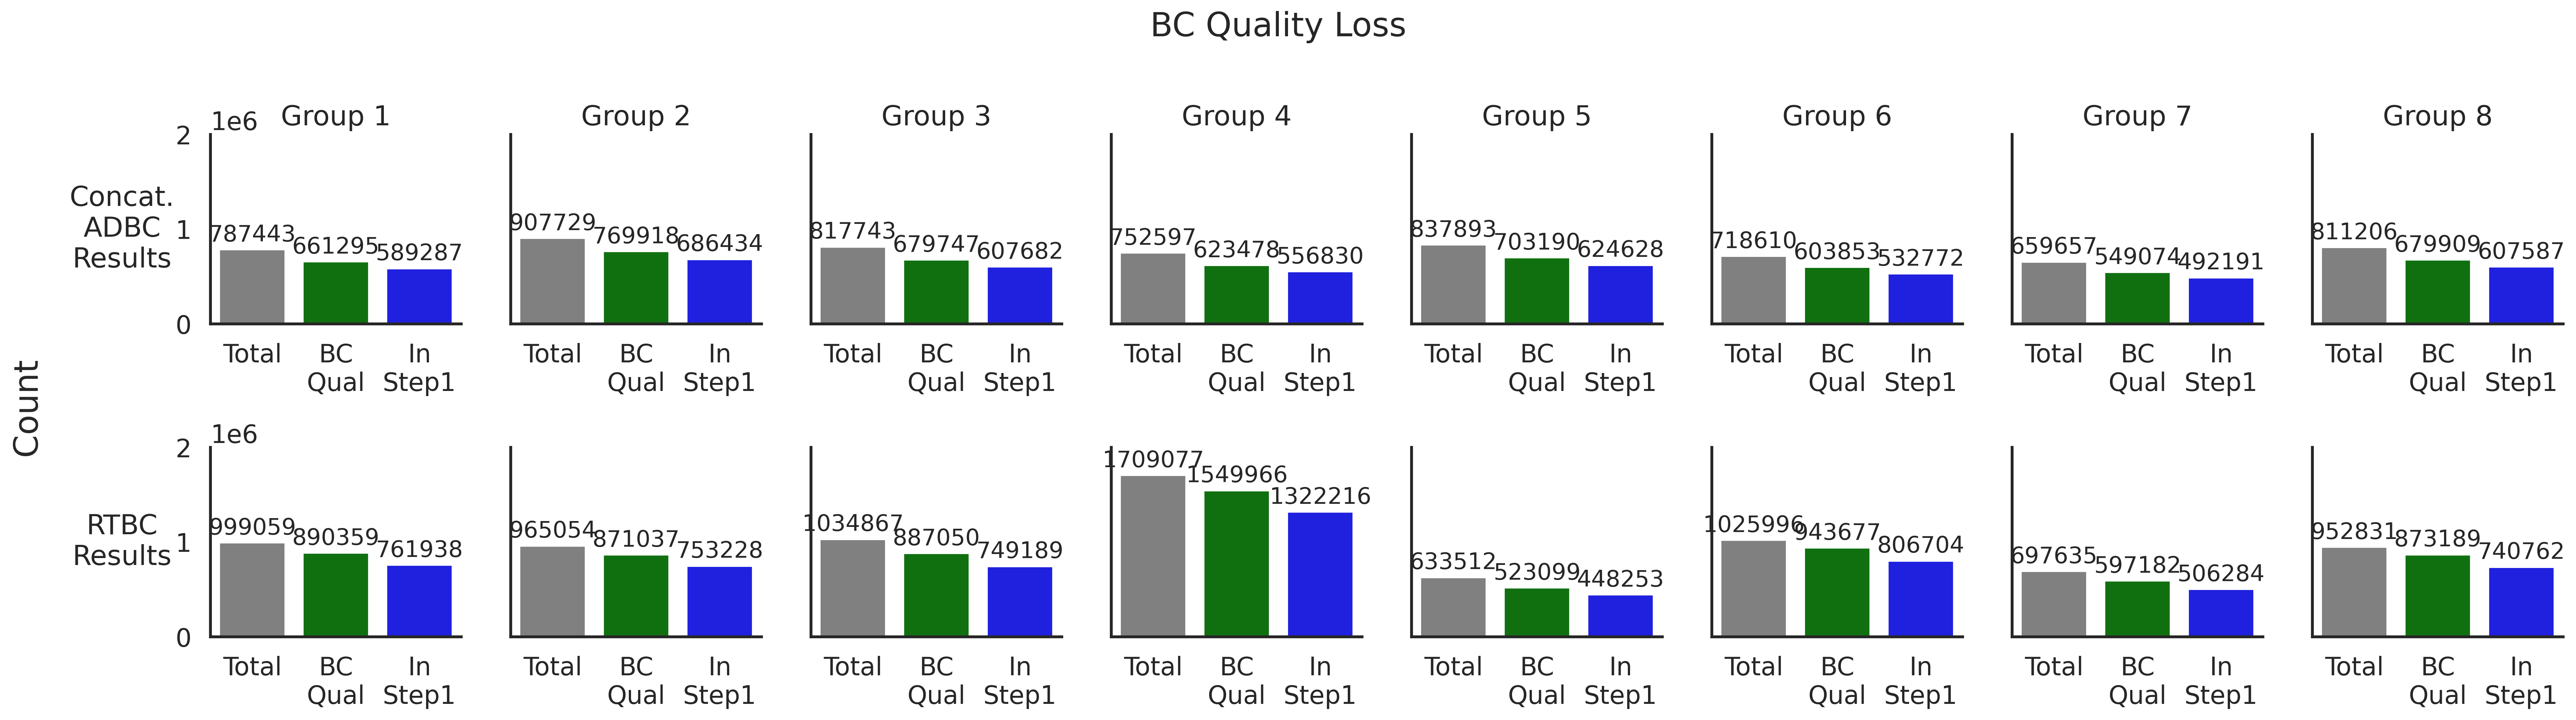

In [23]:
fig, axes = plt.subplots(2, 8, figsize=(24,6), dpi=300, sharey=True, sharex = False)
axes = axes.flatten()  # flatten to index easily 0..15

# First row: AD (ADBC/HawkBCs)
for i in np.arange(1, 9):
    file_name = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_initial'
    df = refiner.get_map_df(file_name)
    
    total_count = len(df)
    both_true = ((df["ADBC2_qual"]) & (df["HawkBCs_qual"])).sum()
    step1_count = len(df[(df["ADBC2"].isin(step1_map["ADBC2"])) & (df["HawkBCs"].isin(step1_map["HawkBCs"]))])
    print(f"{file_name} step1 count: {step1_count}")

    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, both_true, step1_count]
    })

    ax = axes[i - 1]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    ax.set_title("Group " + str(file_name[:6][-1]), fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

# Second row: RPTR (RTBC)
for i in np.arange(1, 9):
    file_name = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_initial'
    df = refiner.get_map_df(file_name)
    
    total_count = len(df)
    true_count = df["RTBC_qual"].sum()  # assuming boolean True/False
    step1_count = len(df[df["RTBC"].isin(step1_map["RTBC"])])
   
    plot_counts = pd.DataFrame({
        "Category": ["Total", "BC\nQual", "In\nStep1"],
        "Count": [total_count, true_count, step1_count]
    })

    ax = axes[8 + i - 1]
    sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green", "blue"])
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize='small', padding=2)

    #ax.set_title(file_name[:6], fontsize='medium')
    ax.set_xlabel("")
    ax.set_ylabel("")

axes[0].set_ylabel("Concat.\nADBC\nResults", rotation = 0, labelpad = 35, va = 'center')
axes[8].set_ylabel("RTBC\nResults", rotation = 0, labelpad = 35, va = 'center')

axes[0].set_ylim(0, 2000000)
fig.supylabel("Count")
sns.despine()
plt.tight_layout(pad = 1)
fig.suptitle("BC Quality Loss", y = 1.1)
plt.savefig(os.path.join(output_path, f"bc_quality_loss.png"))
plt.show()

In [85]:
i = 1
file_name = f'umi_a{i}_RNA_ADBC_S{16 + i}_ADBC2_HawkBCs_initial'
df = refiner.get_map_df(file_name)
ADBC2_nulls = len(df[df["ADBC2"] == ""])
ADBC2_wrong_len = len(df[(df["ADBC2"] != "") & (df["ADBC2"].str.len() != 6)])
ADBC2_qual = len(df[df["ADBC2_qual"]])

HawkBCs_nulls = len(df[df["HawkBCs"] == ""])
HawkBCs_wrong_len = len(df[(df["HawkBCs"] != "") & (df["HawkBCs"].str.len() != 9)])
HawkBCs_qual = len(df[df["HawkBCs_qual"]])

both_good = len(df[(df["HawkBCs_qual"] == True) & (df["ADBC2_qual"] == True)])
df
# total_count = len(df)
# both_true = ((df["ADBC2_qual"]) & (df["HawkBCs_qual"])).sum()

# plot_counts = pd.DataFrame({
#     "Category": ["Total", "BC_Qual"],
#     "Count": [total_count, both_true]
# })

# ax = axes[i-1]
# bars = sns.barplot(x="Category", y="Count", data=plot_counts, ax=ax, palette=["gray", "green"])

# for container in ax.containers:
#     ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, padding=2)

# ax.set_title("Group " + str(file_name[:6][-1]), fontsize='medium')
# ax.set_xlabel("")
# ax.set_ylabel("")

,ADBC2,ADBC2_qual,HawkBCs,HawkBCs_qual,UMI,Designed
0,AAATTG,True,ACATTGCCG,True,TAACACCTGTAC,1
1,ATAGGA,True,AACACAAGC,True,CATTAATACCAG,1
2,TGTAAC,True,AGGACAAGT,True,CGCCGAGAAGTT,1
3,CCAGGA,True,CACCGATTG,True,ACGGCGGCCTCA,1
4,AGTAAA,True,CCGCAGTTA,True,GGATTGTTTTGA,1
...,...,...,...,...,...,...
787438,,False,,False,CTATGATCAACT,1
787439,,False,,False,TCCTTAAAATAG,1
787440,ATCCAC,True,,False,TCACCAGACTTT,1
787441,,False,CCGTGTTGT,True,TTTCGGATATAT,1


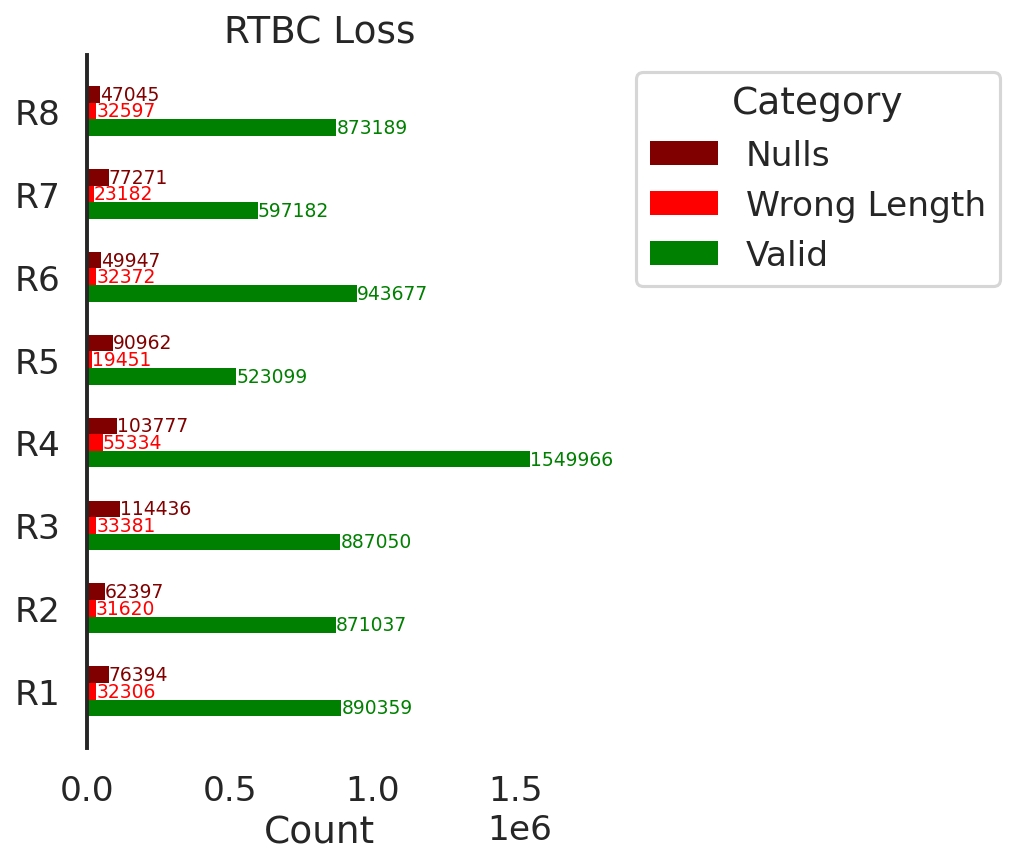

In [93]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=150)

rep_labels = []
segments = {"Nulls": [], "Wrong Length": [], "Valid": []}  # order

bar_height = 0.2  # height of each small segment
y_pos = np.arange(8)  # center y-position for each replicate

for i in np.arange(1, 9):
    file_name = f'umi_r{i}_RNA_RTBC_S{24 + i}_RTBC_initial'
    df = refiner.get_map_df(file_name)
    
    # Compute counts
    num_nulls = len(df[df["RTBC"] == ""])
    len_wrong_length = len(df[(df["RTBC"] != "") & (df["RTBC"].str.len() != 16)])
    len_qual = len(df[df["RTBC_qual"]])
    
    rep_labels.append(f"R{i}")
    segments["Nulls"].append(num_nulls)
    segments["Wrong Length"].append(len_wrong_length)
    segments["Valid"].append(len_qual)

# Colors
category_colors = {"Nulls": "maroon", "Wrong Length": "red", "Valid": "green"}

# Offsets for top → middle → bottom stacking
offsets = {"Nulls": bar_height, "Wrong Length": 0, "Valid": -bar_height}

# Plot each segment
for seg_name in ["Nulls", "Wrong Length", "Valid"]:
    ax.barh(y_pos + offsets[seg_name], segments[seg_name], height=bar_height,
            color=category_colors[seg_name], edgecolor="none", label=seg_name)
    
    # Add labels to the right of each segment
    for y, val in zip(y_pos + offsets[seg_name], segments[seg_name]):
        if val > 0:
            ax.text(val + 5, y, str(val), va='center', ha='left', color=category_colors[seg_name], fontsize=9)

# Y-axis ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(rep_labels)

ax.set_xlabel("Count")
ax.set_title("RTBC Loss")
ax.legend(title="Category", loc = 'upper right', bbox_to_anchor = (2,1))
sns.despine(bottom=True)
plt.tight_layout()
plt.show()

# Reads per UMI

In [111]:
ADBC_reads_per_umi = []

for file_path in AD_seq_files:
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = AD_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    one_file_reads_per_UMI = deduplicator.counts_per_umi()
    one_file_reads_per_UMI["name"] = name_only
    ADBC_reads_per_umi.append(one_file_reads_per_UMI)
    
ADBC_reads_per_umi = pd.concat(ADBC_reads_per_umi)
ADBC_reads_per_umi

a2_RNA_ADBC_S18
a7_RNA_ADBC_S23
a1_RNA_ADBC_S17
a3_RNA_ADBC_S19
a6_RNA_ADBC_S22
a4_RNA_ADBC_S20
a8_RNA_ADBC_S24
a5_RNA_ADBC_S21


,ADBC2,HawkBCs,UMI,reads,name
0,AAAAAA,AACTCCGTA,CGATGAAATCAC,1,a2_RNA_ADBC_S18
1,AAAAAA,ACTCCTGCA,GGTTAACGTAGA,1,a2_RNA_ADBC_S18
2,AAAAAA,ACTCGTGCA,TGAGAAATCAGT,1,a2_RNA_ADBC_S18
3,AAAAAA,ACTCTTGCA,AAAAACTAACTT,4,a2_RNA_ADBC_S18
4,AAAAAA,ACTCTTGCA,ACTCGAAACTTC,3,a2_RNA_ADBC_S18
...,...,...,...,...,...
516321,TTTTTT,AGAGGAGTT,TGCGAAATGGCA,1,a5_RNA_ADBC_S21
516322,TTTTTT,AGAGGAGTT,ACACTTTTTACT,1,a5_RNA_ADBC_S21
516323,TTTTTT,AGAGGAGTT,TATGAATCGGGA,1,a5_RNA_ADBC_S21
516324,TTTTTT,AGAGGCGTT,ACTCATGAAAAT,1,a5_RNA_ADBC_S21


In [114]:
ADBC_reads_per_umi.to_csv(os.path.join(output_path, f"ADBC_reads_per_umi.csv"))

In [115]:
RTBC_reads_per_umi = []
for file_path in RT_seq_files:
    # Get the file naeme to use for database
    base_name = os.path.basename(file_path)
    name_only = base_name.split('.')[0]
    print(name_only) 

    # Run both deduplications
    deduplicator = umi_deduplicate.UMIDeduplicator(db_path = db_path,
                                                        bc_objects = RTBC_objects,
                                                        step_name = f"umi_{name_only}", 
                                                        descriptor = "",
                                                        step1_map_name = None,
                                                        fastq_path = file_path,
                                                        umi_length = 12,
                                                        output_path = umi_path)

    one_file_reads_per_UMI = deduplicator.counts_per_umi()
    one_file_reads_per_UMI["name"] = name_only
    RTBC_reads_per_umi.append(one_file_reads_per_UMI)
RTBC_reads_per_umi = pd.concat(RTBC_reads_per_umi)
RTBC_reads_per_umi

r2_RNA_RTBC_S26
r8_RNA_RTBC_S32
r7_RNA_RTBC_S31
r1_RNA_RTBC_S25
r6_RNA_RTBC_S30
r3_RNA_RTBC_S27
r5_RNA_RTBC_S29
r4_RNA_RTBC_S28


,RTBC,UMI,reads,name
0,AAAAAAAAAAAACGAT,CGAAATCAACTT,2,r2_RNA_RTBC_S26
1,AAAAAAAAAAAACGAT,CTCCCCATCACC,1,r2_RNA_RTBC_S26
2,AAAAAAAAAAAACGAT,CTATATACGTGA,1,r2_RNA_RTBC_S26
3,AAAAAAAAAAAACGAT,GCGTACGACTCA,1,r2_RNA_RTBC_S26
4,AAAAAAAAAAAACGAT,GACACAATTGCA,1,r2_RNA_RTBC_S26
...,...,...,...,...
1027833,TTTTTAGCCGTCATCT,CATCTCTAGGCT,1,r4_RNA_RTBC_S28
1027834,TTTTTGTACGAGTAGA,GCCGATTTTTGT,1,r4_RNA_RTBC_S28
1027835,TTTTTGTACGAGTAGA,AGATGTCCATAT,1,r4_RNA_RTBC_S28
1027836,TTTTTTGAATTTTTAT,TGGAAAAGTAAC,1,r4_RNA_RTBC_S28


In [116]:
RTBC_reads_per_umi.to_csv(os.path.join(output_path, f"RTBC_reads_per_umi.csv"))